In [1]:
import sys
sys.version

'3.10.15 (main, Sep  7 2024, 00:20:06) [Clang 16.0.0 (clang-1600.0.26.3)]'

# Import

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, classification_report, make_scorer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, Normalizer, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_validate, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
import seaborn as sns
import datetime
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from tqdm import tqdm
import os, gc

pd.set_option('display.max_rows', 500)
random_state = 42
np.random.seed(random_state)
data_filepath = Path('./data')
# data_filepath = Path('/kaggle/input/child-mind-institute-problematic-internet-use')
KAPPA_SCORER = make_scorer(
    cohen_kappa_score,
    greater_is_better=True,
    weights='quadratic',
)

# Data

In [3]:
!du -hs $data_filepath/*
train_df = pd.read_csv(data_filepath / 'train.csv')
test_df = pd.read_csv(data_filepath / 'test.csv')
train_df.shape, test_df.shape

6.2G	data/child-mind-institute-problematic-internet-use.zip
 12K	data/data_dictionary.csv
4.0K	data/sample_submission.csv
7.9M	data/series_test.parquet
6.3G	data/series_train.parquet
8.0K	data/test.csv
924K	data/train.csv
268K	data/ts_train_parquet


((3960, 82), (20, 59))

In [3]:
parquet_partitions = list((data_filepath / 'series_train.parquet').glob('id=*'))
len(parquet_partitions), len(set(str(c).split('=')[1] for c in parquet_partitions) & set(train_df.id))

(996, 996)

In [4]:
%%time
def parse_time_of_day(nanoseconds):
    seconds = nanoseconds // 10**9
    nanoseconds_remainder = nanoseconds % 10**9
    time_of_day = datetime.timedelta(seconds=seconds)
    hours, remainder = divmod(time_of_day.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
#     formatted_time = f"{hours:02}:{minutes:02}:{seconds:02}.{nanoseconds_remainder:09}"
    return hours, minutes, seconds, nanoseconds_remainder

def convert_ts_to_row(ts):
    agg_cols = ['X', 'Y', 'Z', 'enmo', 'anglez', 'light', 'battery_voltage']
    onerow = ts[agg_cols].agg(['min', 'max', 'std', 'mean', 'median']).unstack().to_frame().T
    onerow.columns = ['_'.join(c) for c in onerow.columns]
    return onerow

def handle_parquet_partition(partition_filepath):
    user_id = str(partition_filepath).split('=')[-1]
    ts_df = pd.read_parquet(partition_filepath)
    ts_onerow = convert_ts_to_row(ts_df)
    ts_onerow['id'] = user_id
    
    ts_df['day_hour'] = ts_df.time_of_day.apply(lambda x: parse_time_of_day(x)[0])
    ts_df['week'] = ts_df['relative_date_PCIAT'] // 7 + 1
    ts_df['month'] = ts_df['relative_date_PCIAT'] // 30 + 1
    
    # Количество периодов без движения
    # Count of periods without activity
    ts_onerow['total_inactivity_periods'] = ts_df[ts_df.enmo == 0].enmo.count()
    
    # Среднее количество часов активности в день
    # Avg hours of activity per day
    cnt_of_active_hours = ts_df[(ts_df['non-wear_flag'] == 0) & (ts_df.enmo > 0)].drop_duplicates(['relative_date_PCIAT', 'day_hour']).day_hour.count()
    cnt_of_days = len(ts_df['relative_date_PCIAT'].unique())
    ts_onerow['avg_active_hours_per_day'] = (cnt_of_active_hours or 1) / (cnt_of_days or 1)
    
    # weekend flag
    ts_onerow['weekend_flag'] = ts_df.weekday.isin([6,7]).astype(int)
    
    # Hour of pick activity
    # Пиковое время активности для клиента
    peak_hour_of_activity = ts_df[(ts_df['non-wear_flag'] == 0) & (ts_df.enmo > 0)].groupby([ts_df['day_hour']]).enmo.count()
    ts_onerow['peak_hour_of_activity'] = peak_hour_of_activity.sort_values(ascending=False).index[0]
    
    activity_mask = (ts_df['non-wear_flag'] == 0) & (ts_df.enmo > 0)

    # Relation of activity in weekday and weekend
    # Соотношение активности будни/выходные
    weekday_activity = ts_df[activity_mask & (~ts_df.weekday.isin([6,7]))].drop_duplicates().enmo.count()
    weekend_activity = ts_df[activity_mask & (ts_df.weekday.isin([6,7]))].drop_duplicates().enmo.count()
    ts_onerow['weekday_weekend_activity_ratio'] = (weekday_activity or 1) / (weekend_activity or 1)
    
    # Activity in differentn parts of day
    # Активность в разные части дня
    night_mask = (ts_df.day_hour > 0) & (ts_df.day_hour <= 6)
    morning_mask = (ts_df.day_hour > 6) & (ts_df.day_hour <= 12)
    day_mask = (ts_df.day_hour > 12) & (ts_df.day_hour <= 18)
    evening_mask = (ts_df.day_hour > 18) & ((ts_df.day_hour <= 23) | (ts_df.day_hour == 0))
    
    ts_onerow['night_activity'] = ts_df[activity_mask & night_mask].drop_duplicates().enmo.count()
    ts_onerow['morning_activity'] = ts_df[activity_mask & morning_mask].drop_duplicates().enmo.count()
    ts_onerow['day_activity'] = ts_df[activity_mask & day_mask].drop_duplicates().enmo.count()
    ts_onerow['evening_activity'] = ts_df[activity_mask & evening_mask].drop_duplicates().enmo.count()
    
    # Total time of device wear
    # Общее время ношения устройства
    ts_onerow['cnt_of_device_wearing_hours'] = ts_df[(ts_df['non-wear_flag'] == 0)].drop_duplicates(['relative_date_PCIAT', 'day_hour']).day_hour.count()

    # Relation of wearing / no wearing device
    # Соотношение ношения/не ношения устройства
    cnt_of_device_wearing_hours = ts_df[(ts_df['non-wear_flag'] == 0)].drop_duplicates(['relative_date_PCIAT', 'day_hour']).day_hour.count()
    cnt_of_device_no_wearing_hours = ts_df[(ts_df['non-wear_flag'] == 1)].drop_duplicates(['relative_date_PCIAT', 'day_hour']).day_hour.count()
    ts_onerow['relation_of_wearnig_no_wearing'] = (cnt_of_device_wearing_hours or 1) / (cnt_of_device_no_wearing_hours or 1)
    
    # Before / after PCIAT test activitys
    # Активность до и после теста PCIAT
    activity_mask = (ts_df['non-wear_flag'] == 0) & (ts_df.enmo > 0)
    pciat_period_mask = ts_df['relative_date_PCIAT'] >= 0
    pciat_period_activity = ts_df[activity_mask & pciat_period_mask].drop_duplicates().enmo.count()
    pre_pciat_period_activity = ts_df[activity_mask & (~pciat_period_mask)].drop_duplicates().enmo.count()
    ts_onerow['pciat_period_activity'] = pciat_period_activity
    ts_onerow['pre_pciat_period_activity'] = pre_pciat_period_activity
    
    # Relation before / after PCIAT test activitys
    # Соотношение активность до и после теста PCIAT
    ts_onerow['relation_pre_pciat_period_activity'] = (pciat_period_activity or 1) / (pre_pciat_period_activity or 1)
    return ts_onerow

def parse_time_series(parquet_partitions):
    print(f'{os.cpu_count()=}')
    with ThreadPoolExecutor(max_workers=os.cpu_count() * 2) as executor:
        results = list(tqdm(executor.map(lambda fpath: handle_parquet_partition(fpath), parquet_partitions), total=len(parquet_partitions)))
    ts_input = pd.concat(results); del results; gc.collect()
    return ts_input

ts_train = parse_time_series(parquet_partitions)
print(ts_train.memory_usage(deep=True).sum().round() / 1024 / 1024)
ts_train

os.cpu_count()=10


100%|███████████████████████████████████████████████████████████████████████████████████████████| 996/996 [05:11<00:00,  3.19it/s]

0.3011054992675781
CPU times: user 8min 44s, sys: 1min 7s, total: 9min 51s
Wall time: 5min 12s


,X_min,X_max,X_std,X_mean,X_median,Y_min,Y_max,Y_std,Y_mean,Y_median,...,weekday_weekend_activity_ratio,night_activity,morning_activity,day_activity,evening_activity,cnt_of_device_wearing_hours,relation_of_wearnig_no_wearing,pciat_period_activity,pre_pciat_period_activity,relation_pre_pciat_period_activity
0,-3.298790,1.159667,0.429476,-0.478973,-0.578881,-3.262288,2.525316,0.518888,-0.037643,-0.006695,...,2.470115,15122,107835,102308,32750,742,742.000000,259693,0,259693.0
0,-1.777734,1.859814,0.523529,0.047866,0.009822,-2.433394,1.518311,0.441043,0.003234,0.008072,...,3.790427,53484,74549,83781,60292,470,3.333333,281016,0,281016.0
0,-2.163437,1.017271,0.300414,-0.088861,0.005507,-3.142938,1.381445,0.371415,0.045154,0.002966,...,2.359350,35407,8771,4616,16899,236,0.666667,70459,0,70459.0
0,-1.962057,1.148359,0.601258,-0.080044,-0.190000,-2.844661,3.186745,0.595227,0.058017,0.093646,...,2.994780,21848,116472,107894,48693,721,721.000000,296153,0,296153.0
0,-3.150714,2.427422,0.282437,-0.067303,-0.049600,-4.179972,2.343212,0.528473,0.187596,-0.005727,...,3.142478,13523,36575,38233,18853,209,0.572603,109117,0,109117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-2.375542,1.962949,0.278136,0.034996,-0.010207,-2.212997,1.764815,0.594951,0.382648,0.456311,...,6.670877,1034,26603,28023,19281,191,0.395445,75305,0,75305.0
0,-2.023180,1.163996,0.505671,-0.227848,-0.311040,-2.103810,2.271134,0.523569,-0.117374,-0.107125,...,2.446506,5476,24084,30399,10538,247,247.000000,71129,0,71129.0
0,-0.989845,2.261910,0.451261,0.470508,0.604042,-5.156441,1.023213,0.434032,0.069204,0.086445,...,2.892677,85545,99066,103471,81752,559,139.750000,384651,0,384651.0
0,-2.147763,2.621233,0.509230,0.001327,-0.036661,-3.231679,2.709097,0.547428,-0.233908,-0.098634,...,3.166249,51308,68576,65390,43558,403,2.190217,236293,0,236293.0


In [5]:
%%time
ts_train.to_parquet(data_filepath / 'ts_train_parquet')
!du -hs $data_filepath/*

NameError: name 'ts_train' is not defined

In [4]:
%%time
ts_train = pd.read_parquet(data_filepath / 'ts_train_parquet')
train_df = pd.read_csv(data_filepath / 'train.csv')
print(train_df.shape, ts_train.shape)
train_df = pd.merge(train_df, ts_train, on='id', how='left')
train_df.shape

(3960, 82) (996, 50)
CPU times: user 62.2 ms, sys: 15.7 ms, total: 77.9 ms
Wall time: 80.4 ms


(3960, 131)

In [4]:
def feature_engineering(df):
    # season_cols = [col for col in df.columns if 'Season' in col]
    # df = df.drop(season_cols, axis=1)
    pciat_cols = [c for c in df.columns if c.startswith('PCIAT')]
    df = df.drop(columns=pciat_cols, errors='ignore')
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']

    df['Age_Weight'] = df['Basic_Demos-Age'] * df['Physical-Weight']
    df['Sex_BMI'] = df['Basic_Demos-Sex'] * df['Physical-BMI']
    df['Sex_HeartRate'] = df['Basic_Demos-Sex'] * df['Physical-HeartRate']
    df['Age_WaistCirc'] = df['Basic_Demos-Age'] * df['Physical-Waist_Circumference']
    df['BMI_FitnessMaxStage'] = df['Physical-BMI'] * df['Fitness_Endurance-Max_Stage']
    df['Weight_GripStrengthDominant'] = df['Physical-Weight'] * df['FGC-FGC_GSD']
    df['Weight_GripStrengthNonDominant'] = df['Physical-Weight'] * df['FGC-FGC_GSND']
    df['HeartRate_FitnessTime'] = df['Physical-HeartRate'] * (df['Fitness_Endurance-Time_Mins'] + df['Fitness_Endurance-Time_Sec'])
    df['Age_PushUp'] = df['Basic_Demos-Age'] * df['FGC-FGC_PU']
    df['FFMI_Age'] = df['BIA-BIA_FFMI'] * df['Basic_Demos-Age']
    df['InternetUse_SleepDisturbance'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['SDS-SDS_Total_Raw']
    df['CGAS_BMI'] = df['CGAS-CGAS_Score'] * df['Physical-BMI']
    df['CGAS_FitnessMaxStage'] = df['CGAS-CGAS_Score'] * df['Fitness_Endurance-Max_Stage']
    return df

train_df = feature_engineering(train_df)
train_df = train_df.replace([np.inf, -np.inf], np.nan)

In [5]:
train_df.sii.value_counts(dropna=False)

0.0    1594
NaN    1224
1.0     730
2.0     378
3.0      34
Name: sii, dtype: int64

In [6]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM

In [8]:
# cat_cols = train_df.select_dtypes(include='object').columns.tolist()
num_cols = train_df.drop(columns=['id', 'sii']).select_dtypes(include='number').columns.tolist()
num_cols_sii = train_df.drop(columns='id').select_dtypes(include='number').columns.tolist()
imputer = KNNImputer(n_neighbors=5)
train_df.loc[:,num_cols] = imputer.fit_transform(train_df[num_cols])
train_df['sii'] = train_df['sii'].fillna(pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(train_df[num_cols_sii]), columns=num_cols_sii).sii)
train_df['sii'] = train_df.sii.round().astype(int)
train_df.sii.value_counts(dropna=False)

/var/folders/p1/mwwgzyc520lbbnx_47zdxcl80000gn/T/ipykernel_68469/3039269917.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_df.loc[:,num_cols] = imputer.fit_transform(train_df[num_cols])


0    2199
1    1329
2     398
3      34
Name: sii, dtype: int64

In [9]:
train_df.isna().sum()

id                                           0
Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
CGAS-CGAS_Score                              0
Physical-Season                            650
Physical-BMI                                 0
Physical-Height                              0
Physical-Weight                              0
Physical-Waist_Circumference                 0
Physical-Diastolic_BP                        0
Physical-HeartRate                           0
Physical-Systolic_BP                         0
Fitness_Endurance-Season                  2652
Fitness_Endurance-Max_Stage                  0
Fitness_Endurance-Time_Mins                  0
Fitness_Endurance-Time_Sec                   0
FGC-Season                                 614
FGC-FGC_CU                                   0
FGC-FGC_CU_Zone                              0
FGC-FGC_GSND 

In [13]:
train_df.shape

(3960, 88)

In [14]:
train_df = train_df.dropna(axis=1)

In [18]:
N_THREADS = 6
N_FOLDS = 5
RANDOM_STATE = random_state
TEST_SIZE = 0.2
TIMEOUT = 60 * 15
TARGET_NAME = 'sii'

def automl_cohen_kappa_score(y_true, y_pred, **kwargs):
    return cohen_kappa_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

task = Task('multiclass')
roles = {
    'target': TARGET_NAME,
    'drop': ['id']
}

In [19]:
train_data, test_data = train_test_split(
    train_df,
    test_size=TEST_SIZE,
    stratify=train_df[TARGET_NAME],
    random_state=RANDOM_STATE
)
train_data.shape, test_data.shape

((3168, 79), (792, 79))

In [23]:
automl = TabularUtilizedAutoML( #TabularAutoML
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [24]:
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 1)

[00:06:33] Start automl utilizator with listed constraints:
[00:06:33] - time: 900.00 seconds
[00:06:33] - CPU: 6 cores
[00:06:33] - memory: 16 GB

[00:06:33] If one preset completes earlier, next preset configuration will be started

[00:06:33] ==================================================
[00:06:33] Start 0 automl preset configuration:
[00:06:33] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[00:06:33] Stdout logging level is INFO.
[00:06:33] Task: multiclass

[00:06:33] Start automl preset with listed constraints:
[00:06:33] - time: 900.00 seconds
[00:06:33] - CPU: 6 cores
[00:06:33] - memory: 16 GB

[00:06:33] Train data shape: (3168, 79)

[00:06:35] Layer 1 train process start. Time left 898.04 secs
[00:06:35] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[00:06:40] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.8008976483574692
[00:06:40] Lvl_0_Pip

In [25]:
test_predictions = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_predictions[:10]}\nShape = {test_predictions.shape}')

Prediction for te_data:
array([[2.2263756e-01, 6.3819009e-01, 1.3248160e-01, 6.6907620e-03],
       [9.2075950e-01, 6.6338427e-02, 1.2637258e-02, 2.6471727e-04],
       [5.4812288e-01, 2.6807952e-01, 1.7740215e-01, 6.3955379e-03],
       [1.3207391e-01, 8.2053685e-01, 4.4713870e-02, 2.6754020e-03],
       [4.7039080e-01, 4.9866122e-01, 2.9028330e-02, 1.9196700e-03],
       [2.4098152e-01, 5.4160464e-01, 1.5034446e-01, 6.7069441e-02],
       [7.2901362e-01, 2.4951312e-01, 2.1009337e-02, 4.6393846e-04],
       [3.2338309e-01, 6.5458322e-01, 2.0710111e-02, 1.3236401e-03],
       [5.0653476e-01, 4.6034127e-01, 3.2067116e-02, 1.0568852e-03],
       [6.6415787e-01, 3.1769919e-01, 1.7029250e-02, 1.1136276e-03]],
      dtype=float32)
Shape = (792, 4)


In [26]:
print(f'OOF score: {automl_cohen_kappa_score(train_data[roles["target"]].values, out_of_fold_predictions.data[:, 0])}')
print(f'HOLDOUT score: {automl_cohen_kappa_score(test_data[roles["target"]].values, test_predictions.data[:, 0])}')

OOF score: -0.4398044611457981
HOLDOUT score: -0.3266331658291457


In [58]:
explainer = SSWARM(automl)
shap_values = explainer.shap_values(test_data, n_jobs=N_THREADS)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:26<00:00, 11.25it/s]


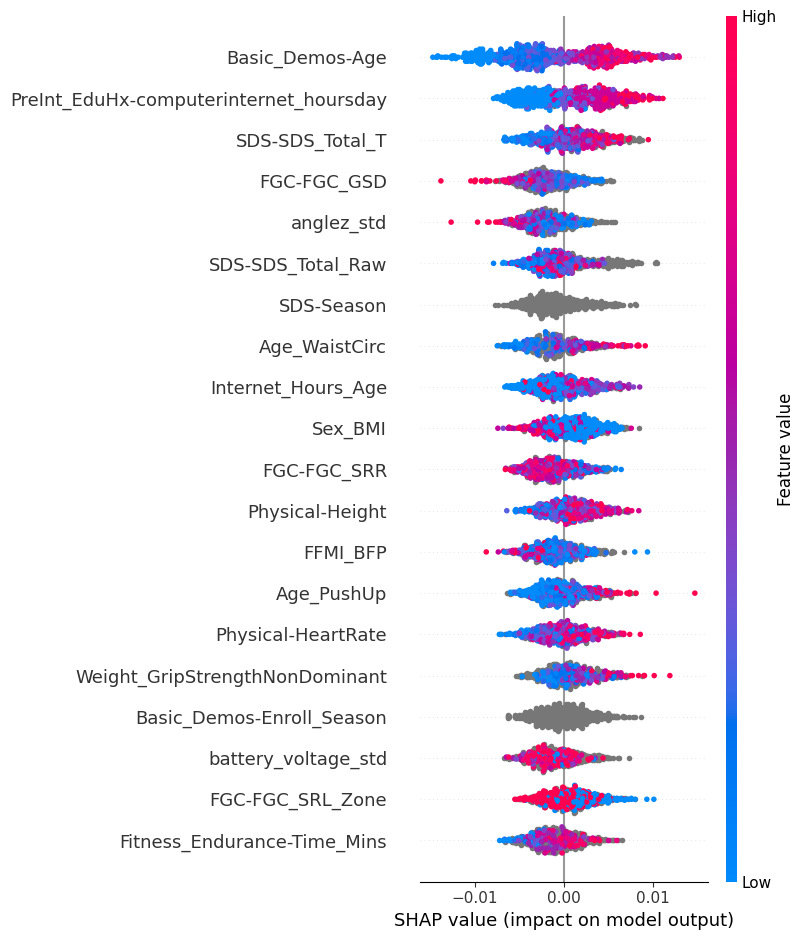

In [68]:
import shap
shap.summary_plot(shap_values[1], test_data[explainer.used_feats])